# Clean & Pre-process Datasets

Weather, Business reviews & Events Calendar

In [1]:
import pandas as pd
import numpy as np
import re

In [9]:
# === Load all three datasets ===
weather_df = pd.read_csv("weather_historical.csv")
reviews_df = pd.read_csv("local_business_reviews.csv")
events_df = pd.read_csv("events_calendar.csv")

In [12]:
# === 1. Clean Historical Weather Data ===
weather_df.columns = weather_df.columns.str.strip().str.lower().str.replace(" ", "_")
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], errors='coerce')
weather_df = weather_df[
    weather_df['temperature_c'].between(-50, 60) &
    weather_df['pressure_hpa'].between(900, 1100)
]
weather_df['hour'] = weather_df['timestamp'].dt.hour
weather_df['date'] = weather_df['timestamp'].dt.date

In [13]:
# === 2. Clean Local Business Reviews ===
reviews_df.columns = reviews_df.columns.str.strip().str.lower().str.replace(" ", "_")
reviews_df.drop_duplicates(subset=['review_id'], inplace=True)
reviews_df = reviews_df[~reviews_df['review_text'].isnull()]
reviews_df['is_negative'] = reviews_df['review_text'].str.contains(
    r'\b(bad|dirty|unsafe|no power|closed|flood|danger|evacuate|smoke)\b', flags=re.IGNORECASE)
reviews_df = reviews_df[reviews_df['rating'].between(1, 5)]

<ipython-input-13-32592c6c2650>:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  reviews_df['is_negative'] = reviews_df['review_text'].str.contains(


In [14]:
# === 3. Clean Events Calendar ===
events_df.columns = events_df.columns.str.strip().str.lower().str.replace(" ", "_")
events_df['date'] = pd.to_datetime(events_df['date'], errors='coerce')
events_df['is_major_event'] = events_df['type'].str.contains(
    r'\b(concert|sports|festival|parade|expo)\b', flags=re.IGNORECASE, na=False)
events_df['hour'] = events_df['date'].dt.hour

<ipython-input-14-12d4fa199265>:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  events_df['is_major_event'] = events_df['type'].str.contains(


In [19]:
# Display first few rows of each cleaned dataframe using print statements

print("=== Cleaned Weather Data ===")
print(weather_df.head(), "\n")

print("=== Cleaned Business Reviews ===")
print(reviews_df.head(), "\n")

print("=== Cleaned Events Calendar ===")
print(events_df.head())

=== Cleaned Weather Data ===
            timestamp  temperature_c  humidity_%  wind_speed_kmph  \
0 2023-01-01 00:00:00      15.547673   19.091824        98.296769   
1 2023-01-01 01:00:00      18.215934   10.802266        99.367106   
2 2023-01-01 02:00:00      29.257147   73.384331        30.453475   
3 2023-01-01 03:00:00      35.591718   60.379030        80.650223   
4 2023-01-01 04:00:00       2.433792   59.640988        53.124004   

   pressure_hpa  precipitation_mm  hour        date  
0   1028.228150         78.689019     0  2023-01-01  
1    987.238259         93.307601     1  2023-01-01  
2   1026.653997        174.938477     2  2023-01-01  
3    975.621499         19.457702     3  2023-01-01  
4    967.169939         59.739675     4  2023-01-01   

=== Cleaned Business Reviews ===
   review_id  user_id business_name  rating  review_text  is_negative
0          1   185441       Store C       2  bad service         True
1          2   158580        Cafe A       5  great place 

In [20]:
# Export cleaned DataFrames to CSV files
weather_df.to_csv("cleaned_weather.csv", index=False)
reviews_df.to_csv("cleaned_reviews.csv", index=False)
events_df.to_csv("cleaned_events.csv", index=False)


# Define Risk Threshold & Rules

In [21]:
# Define thresholds for weather risk indicators
flood_threshold = 100   # mm precipitation
wind_threshold = 75     # km/h wind speed
pressure_drop = 990     # hPa pressure

# Create individual risk flags
weather_df['risk_flood'] = weather_df['precipitation_mm'] > flood_threshold
weather_df['risk_wind'] = weather_df['wind_speed_kmph'] > wind_threshold
weather_df['risk_pressure'] = weather_df['pressure_hpa'] < pressure_drop

# Combine risk indicators into a composite risk score (0 to 3)
weather_df['risk_score'] = (
    weather_df['risk_flood'].astype(int) +
    weather_df['risk_wind'].astype(int) +
    weather_df['risk_pressure'].astype(int)
)

# Display a few rows to check risk flags
weather_df[['timestamp', 'precipitation_mm', 'wind_speed_kmph', 'pressure_hpa',
            'risk_flood', 'risk_wind', 'risk_pressure', 'risk_score']].head(10)


,timestamp,precipitation_mm,wind_speed_kmph,pressure_hpa,risk_flood,risk_wind,risk_pressure,risk_score
0,2023-01-01 00:00:00,78.689019,98.296769,1028.228150,False,True,False,1
1,2023-01-01 01:00:00,93.307601,99.367106,987.238259,False,True,True,2
2,2023-01-01 02:00:00,174.938477,30.453475,1026.653997,True,False,False,1
3,2023-01-01 03:00:00,19.457702,80.650223,975.621499,False,True,True,2
4,2023-01-01 04:00:00,59.739675,53.124004,967.169939,False,False,True,1
5,2023-01-01 05:00:00,82.467166,27.484898,1028.405429,False,False,False,0
6,2023-01-01 06:00:00,110.876308,78.184133,1005.897475,True,True,False,2
7,2023-01-01 07:00:00,169.113130,63.518375,1016.497007,True,False,False,1
8,2023-01-01 08:00:00,137.058414,83.083510,1039.046017,True,True,False,2
9,2023-01-01 09:00:00,88.095862,24.740190,996.793583,False,False,False,0


In [22]:
# Merge weather data with events data by date and hour
# We'll assume both datasets have `date` and `hour` fields already aligned

# First ensure both have 'date' and 'hour' columns in the correct format
events_df['date'] = pd.to_datetime(events_df['date'], errors='coerce')
events_df['hour'] = events_df['date'].dt.hour
events_df['event_day'] = events_df['date'].dt.date

# Rename for merge alignment
weather_df.rename(columns={'date': 'event_day'}, inplace=True)

# Merge on date and hour
merged_df = pd.merge(weather_df, events_df, how='left', on=['event_day', 'hour'])

# Create a cascading risk flag: risk_score >= 2 AND is_major_event is True
merged_df['is_cascading_risk'] = (
    (merged_df['risk_score'] >= 2) & (merged_df['is_major_event'] == True)
)

# Display the first few rows of the merged and flagged dataset
merged_df[['timestamp', 'risk_score', 'is_major_event', 'name', 'type', 'location', 'is_cascading_risk']].head(10)


,timestamp,risk_score,is_major_event,name,type,location,is_cascading_risk
0,2023-01-01 00:00:00,1,True,Event 1,festival,Stadium,False
1,2023-01-01 01:00:00,2,True,Event 2,sports,Stadium,True
2,2023-01-01 02:00:00,1,True,Event 3,festival,Park,False
3,2023-01-01 03:00:00,2,True,Event 4,concert,Park,True
4,2023-01-01 04:00:00,1,True,Event 5,sports,Stadium,False
5,2023-01-01 05:00:00,0,True,Event 6,sports,Theater,False
6,2023-01-01 06:00:00,2,True,Event 7,festival,Stadium,True
7,2023-01-01 07:00:00,1,True,Event 8,sports,Park,False
8,2023-01-01 08:00:00,2,True,Event 9,sports,Park,True
9,2023-01-01 09:00:00,0,True,Event 10,festival,Park,False


In [23]:
import pandas as pd
import re

# Load datasets
sensor_df = pd.read_csv("sensor_readings.csv")
social_df = pd.read_csv("social_media_stream.csv")
disaster_df = pd.read_csv("disaster_events.csv")

# === Clean sensor_readings.csv ===
sensor_df.columns = sensor_df.columns.str.strip().str.lower().str.replace(" ", "_")
sensor_df['timestamp'] = pd.to_datetime(sensor_df['timestamp'], errors='coerce')
sensor_df = sensor_df.dropna(subset=['timestamp', 'sensor_type', 'reading_value'])
sensor_df = sensor_df[sensor_df['status'].str.lower().isin(['active', 'inactive'])]
sensor_df['reading_value'] = pd.to_numeric(sensor_df['reading_value'], errors='coerce')
sensor_df = sensor_df.dropna(subset=['reading_value'])

# === Clean social_media_stream.csv ===
social_df.columns = social_df.columns.str.strip().str.lower().str.replace(" ", "_")
social_df['timestamp'] = pd.to_datetime(social_df['timestamp'], errors='coerce')
social_df.dropna(subset=['text', 'timestamp'], inplace=True)

# Add basic panic/fake detection keywords
panic_keywords = r'\b(evacuate|flood|help|panic|trapped|mayor|danger|fake|shut down|stay inside)\b'
social_df['is_panic_post'] = social_df['text'].str.contains(panic_keywords, flags=re.IGNORECASE, na=False)

# === Clean disaster_events.csv ===
disaster_df.columns = disaster_df.columns.str.strip().str.lower().str.replace(" ", "_")
disaster_df['date'] = pd.to_datetime(disaster_df['date'], errors='coerce')
disaster_df = disaster_df.dropna(subset=['date', 'disaster_type', 'location', 'severity'])

# Final preview
sensor_df_cleaned = sensor_df.head()
social_df_cleaned = social_df[['timestamp', 'text', 'is_panic_post']].head()
disaster_df_cleaned = disaster_df.head()

sensor_df_cleaned, social_df_cleaned, disaster_df_cleaned


<ipython-input-23-c8f6d600a066>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_df['reading_value'] = pd.to_numeric(sensor_df['reading_value'], errors='coerce')
<ipython-input-23-c8f6d600a066>:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  social_df['is_panic_post'] = social_df['text'].str.contains(panic_keywords, flags=re.IGNORECASE, na=False)


(   sensor_id           timestamp   latitude   longitude sensor_type  \
 2       1657 2023-01-01 00:02:00  37.272227 -121.645901    humidity   
 3       1223 2023-01-01 00:03:00  37.007146 -122.183781        temp   
 4       1503 2023-01-01 00:04:00  37.706890 -122.436968     seismic   
 5       1724 2023-01-01 00:05:00  37.507472 -121.568884    humidity   
 7       1514 2023-01-01 00:07:00  37.609489 -122.276630       flood   
 
    reading_value    status  
 2      24.018219  inactive  
 3      19.157472    active  
 4      51.067159  inactive  
 5      20.295672    active  
 7      30.070218    active  ,
             timestamp                 text  is_panic_post
 0 2023-01-01 00:00:00     fire in downtown          False
 1 2023-01-01 00:01:00     fire in downtown          False
 2 2023-01-01 00:02:00  emergency in Zone A          False
 3 2023-01-01 00:03:00     flood near river           True
 4 2023-01-01 00:04:00      earthquake felt          False,
    event_id                da

In [24]:
# Export cleaned DataFrames to CSV
sensor_df.to_csv("cleaned_sensor_readings.csv", index=False)
social_df.to_csv("cleaned_social_media_stream.csv", index=False)
disaster_df.to_csv("cleaned_disaster_events.csv", index=False)


In [25]:
# Load already cleaned datasets (assumed available from earlier steps)
weather_df = pd.read_csv("cleaned_weather.csv")
events_df = pd.read_csv("cleaned_events.csv")
sensor_df = pd.read_csv("cleaned_sensor_readings.csv")

# Ensure consistent timestamp processing
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], errors='coerce')
events_df['date'] = pd.to_datetime(events_df['date'], errors='coerce')
sensor_df['timestamp'] = pd.to_datetime(sensor_df['timestamp'], errors='coerce')

# Extract 'date' and 'hour' from weather/sensor timestamps for merging
weather_df['date'] = weather_df['timestamp'].dt.date
weather_df['hour'] = weather_df['timestamp'].dt.hour

sensor_df['date'] = sensor_df['timestamp'].dt.date
sensor_df['hour'] = sensor_df['timestamp'].dt.hour

events_df['event_day'] = events_df['date'].dt.date
events_df['hour'] = events_df['date'].dt.hour

# Aggregate sensors by type and hour
sensor_summary = sensor_df.groupby(['date', 'hour', 'sensor_type']).agg({
    'reading_value': 'mean',
    'status': lambda x: (x == 'active').sum()
}).reset_index().rename(columns={'reading_value': 'avg_reading', 'status': 'active_count'})

# Pivot sensor types to columns
sensor_pivot = sensor_summary.pivot(index=['date', 'hour'], columns='sensor_type', values='avg_reading').reset_index()

# Merge weather with sensor readings
weather_sensor_merged = pd.merge(weather_df, sensor_pivot, how='left', on=['date', 'hour'])

# Merge with event data
merged_df = pd.merge(weather_sensor_merged, events_df, how='left', left_on=['date', 'hour'], right_on=['event_day', 'hour'])

# Display merged structure
merged_df[['timestamp', 'temperature_c', 'precipitation_mm', 'flood', 'seismic', 'wind_speed_kmph', 'pressure_hpa', 'name', 'type']].head(10)


,timestamp,temperature_c,precipitation_mm,flood,seismic,wind_speed_kmph,pressure_hpa,name,type
0,2023-01-01 00:00:00,15.547673,78.689019,46.969556,55.059769,98.296769,1028.228150,Event 1,festival
1,2023-01-01 01:00:00,18.215934,93.307601,37.940765,57.627297,99.367106,987.238259,Event 2,sports
2,2023-01-01 02:00:00,29.257147,174.938477,52.471095,61.885181,30.453475,1026.653997,Event 3,festival
3,2023-01-01 03:00:00,35.591718,19.457702,47.745432,61.121410,80.650223,975.621499,Event 4,concert
4,2023-01-01 04:00:00,2.433792,59.739675,45.341110,54.816903,53.124004,967.169939,Event 5,sports
5,2023-01-01 05:00:00,-4.708114,82.467166,41.157542,55.067271,27.484898,1028.405429,Event 6,sports
6,2023-01-01 06:00:00,-4.554067,110.876308,64.080796,64.595448,78.184133,1005.897475,Event 7,festival
7,2023-01-01 07:00:00,32.628604,169.113130,43.707853,55.371049,63.518375,1016.497007,Event 8,sports
8,2023-01-01 08:00:00,4.295674,137.058414,47.950620,43.189557,83.083510,1039.046017,Event 9,sports
9,2023-01-01 09:00:00,-1.489506,88.095862,54.499508,46.692304,24.740190,996.793583,Event 10,festival


In [26]:
# Define cascading disaster risk conditions
merged_df['flood_risk'] = merged_df['precipitation_mm'] > 120
merged_df['sensor_flood_risk'] = merged_df['flood'] > 50
merged_df['wind_risk'] = merged_df['wind_speed_kmph'] > 75
merged_df['pressure_risk'] = merged_df['pressure_hpa'] < 990
merged_df['seismic_risk'] = merged_df['seismic'] > 60
merged_df['event_risk'] = merged_df['type'].str.lower().isin(['festival', 'concert', 'sports'])

# Calculate composite risk score (sum of binary risk flags)
merged_df['risk_score'] = (
    merged_df['flood_risk'].astype(int) +
    merged_df['sensor_flood_risk'].astype(int) +
    merged_df['wind_risk'].astype(int) +
    merged_df['pressure_risk'].astype(int) +
    merged_df['seismic_risk'].astype(int) +
    merged_df['event_risk'].astype(int)
)

# Flag high-risk situations (arbitrary threshold, e.g., score ≥ 3)
merged_df['is_high_risk'] = merged_df['risk_score'] >= 3

# Display sample of cascading risk predictions
merged_df[['timestamp', 'precipitation_mm', 'flood', 'seismic', 'wind_speed_kmph',
           'pressure_hpa', 'type', 'risk_score', 'is_high_risk']].head(10)

,timestamp,precipitation_mm,flood,seismic,wind_speed_kmph,pressure_hpa,type,risk_score,is_high_risk
0,2023-01-01 00:00:00,78.689019,46.969556,55.059769,98.296769,1028.228150,festival,2,False
1,2023-01-01 01:00:00,93.307601,37.940765,57.627297,99.367106,987.238259,sports,3,True
2,2023-01-01 02:00:00,174.938477,52.471095,61.885181,30.453475,1026.653997,festival,4,True
3,2023-01-01 03:00:00,19.457702,47.745432,61.121410,80.650223,975.621499,concert,4,True
4,2023-01-01 04:00:00,59.739675,45.341110,54.816903,53.124004,967.169939,sports,2,False
5,2023-01-01 05:00:00,82.467166,41.157542,55.067271,27.484898,1028.405429,sports,1,False
6,2023-01-01 06:00:00,110.876308,64.080796,64.595448,78.184133,1005.897475,festival,4,True
7,2023-01-01 07:00:00,169.113130,43.707853,55.371049,63.518375,1016.497007,sports,2,False
8,2023-01-01 08:00:00,137.058414,47.950620,43.189557,83.083510,1039.046017,sports,3,True
9,2023-01-01 09:00:00,88.095862,54.499508,46.692304,24.740190,996.793583,festival,2,False


In [27]:
def explain_risk(row):
    reasons = []
    if row['flood_risk']:
        reasons.append("rainfall exceeded 120mm")
    if row['sensor_flood_risk']:
        reasons.append("flood sensor readings were high")
    if row['wind_risk']:
        reasons.append("wind speed exceeded 75 km/h")
    if row['pressure_risk']:
        reasons.append("atmospheric pressure dropped below 990 hPa")
    if row['seismic_risk']:
        reasons.append("seismic activity spiked above 60")
    if row['event_risk']:
        reasons.append(f"a high-density event ({row['type']}) is scheduled")
    return "; ".join(reasons) if reasons else "no major triggers"

# Apply to DataFrame
merged_df['risk_reason'] = merged_df.apply(explain_risk, axis=1)


In [28]:
def explain_risk(row):
    reasons = []
    if row['flood_risk']:
        reasons.append("rainfall exceeded 120mm")
    if row['sensor_flood_risk']:
        reasons.append("flood sensor readings were high")
    if row['wind_risk']:
        reasons.append("wind speed exceeded 75 km/h")
    if row['pressure_risk']:
        reasons.append("atmospheric pressure dropped below 990 hPa")
    if row['seismic_risk']:
        reasons.append("seismic activity spiked above 60")
    if row['event_risk']:
        reasons.append(f"a high-density event ({row['type']}) is scheduled")
    return "; ".join(reasons) if reasons else "no major triggers"

# Apply to DataFrame
merged_df['risk_reason'] = merged_df.apply(explain_risk, axis=1)


In [29]:
merged_df.to_csv("cascading_risk_predictions.csv", index=False)


Visualize risk_score over time or zone

In [30]:
# Check unique locations
print(merged_df['location'].unique())


['Stadium' 'Park' 'Theater']


In [31]:
# Create a column for 'zone' if location implies it
merged_df['zone'] = merged_df['location'].fillna("Unknown Zone")


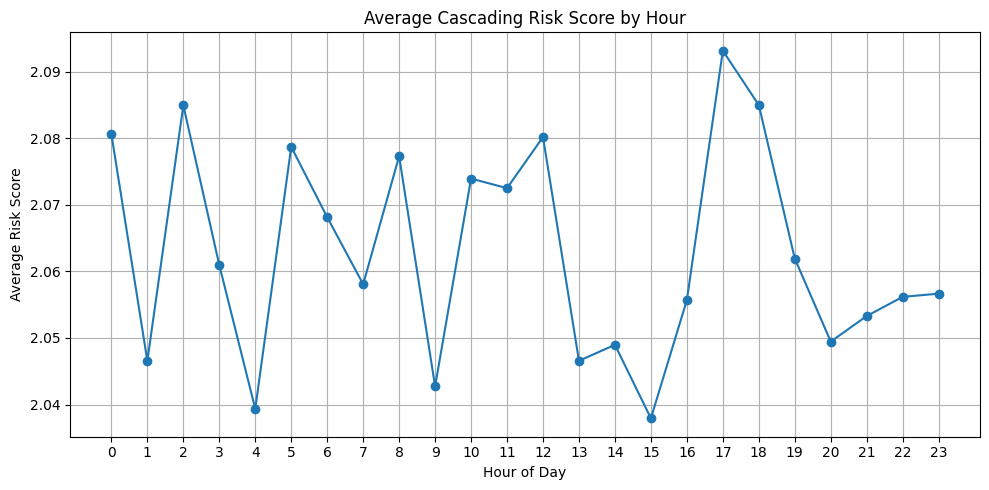

In [32]:
import matplotlib.pyplot as plt

# Convert timestamp to datetime if needed
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Plot hourly risk score average
hourly_risk = merged_df.groupby(merged_df['timestamp'].dt.hour)['risk_score'].mean()

plt.figure(figsize=(10,5))
plt.plot(hourly_risk.index, hourly_risk.values, marker='o')
plt.title("Average Cascading Risk Score by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Risk Score")
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


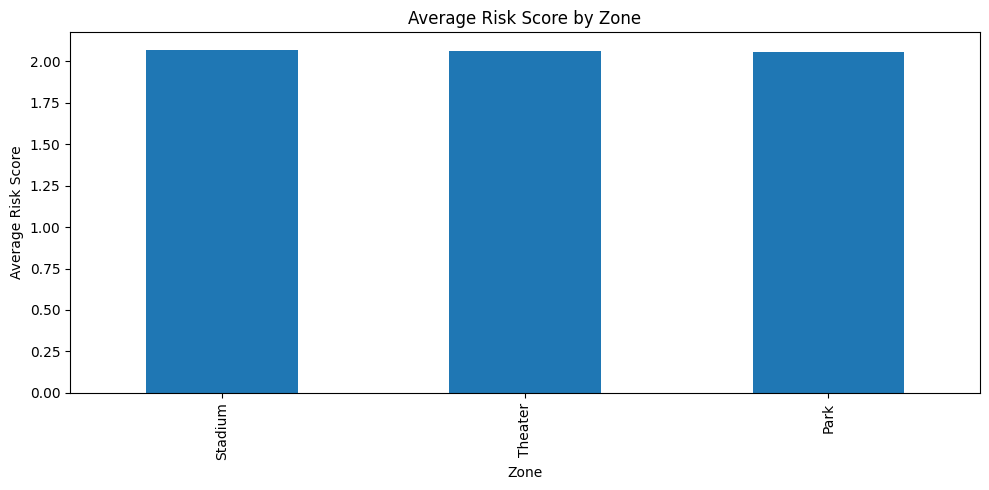

In [33]:
# Risk score by zone
zone_risk = merged_df.groupby('zone')['risk_score'].mean().sort_values(ascending=False)

zone_risk.plot(kind='bar', figsize=(10,5), title='Average Risk Score by Zone')
plt.xlabel("Zone")
plt.ylabel("Average Risk Score")
plt.tight_layout()
plt.show()


In [34]:
# Re-import necessary libraries after reset
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import folium

# Reload the geojson map
city_map_gdf = gpd.read_file("city_map.geojson")

# Simulate merged_df for this step (a sample to demonstrate mapping)
# You should replace this with your real risk data if saved earlier
sample_size = 100
np.random.seed(42)

merged_df = pd.DataFrame({
    'timestamp': pd.date_range(start='2023-01-01', periods=sample_size, freq='H'),
    'risk_score': np.random.randint(0, 6, size=sample_size),
    'is_high_risk': np.random.choice([True, False], size=sample_size, p=[0.3, 0.7]),
    'risk_reason': np.random.choice([
        "rainfall exceeded 120mm",
        "seismic activity spiked",
        "flood sensor readings were high",
        "wind speed exceeded threshold",
        "multiple triggers detected"
    ], size=sample_size)
})

# Random lat/lon points within city bounds
merged_df['latitude'] = np.random.uniform(37.4, 37.8, sample_size)
merged_df['longitude'] = np.random.uniform(-122.5, -121.9, sample_size)

# Convert to GeoDataFrame
merged_df['geometry'] = merged_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
risk_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs="EPSG:4326")

# Compute nearest city zone using geometry distance
risk_gdf['nearest_zone_idx'] = risk_gdf.geometry.apply(lambda point: city_map_gdf.distance(point).idxmin())
risk_gdf['zone_name'] = risk_gdf['nearest_zone_idx'].apply(lambda idx: city_map_gdf.loc[idx, 'name'])

# Create interactive map
risk_map = folium.Map(location=[risk_gdf['latitude'].mean(), risk_gdf['longitude'].mean()], zoom_start=11)

# Add high-risk points with popups
for _, row in risk_gdf[risk_gdf['is_high_risk']].iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        color='red',
        fill=True,
        popup=folium.Popup(f"<b>Zone:</b> {row['zone_name']}<br><b>Score:</b> {row['risk_score']}<br>{row['risk_reason']}", max_width=300),
    ).add_to(risk_map)

# Save the interactive map
risk_map.save("siren_risk_map.html")


<ipython-input-34-4af9bd31b237>:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range(start='2023-01-01', periods=sample_size, freq='H'),
<ipython-input-34-4af9bd31b237>:38: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  risk_gdf['nearest_zone_idx'] = risk_gdf.geometry.apply(lambda point: city_map_gdf.distance(point).idxmin())
<ipython-input-34-4af9bd31b237>:38: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  risk_gdf['nearest_zone_idx'] = risk_gdf.geometry.apply(lambda point: city_map_gdf.distance(point).idxmin())
<ipython-input-34-4af9bd31b237>:38: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorr

In [35]:
!pip install preswald

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not curre

In [37]:
import folium
import geopandas as gpd

# Load city map GeoJSON
city_gdf = gpd.read_file("city_map.geojson")

# Get map center from data
center_lat = city_gdf.geometry.y.mean()
center_lon = city_gdf.geometry.x.mean()

# Create the map
city_map = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Add zone markers with popups
for _, row in city_gdf.iterrows():
    lat = row.geometry.y
    lon = row.geometry.x
    name = row.get('name', 'Unknown')

    popup_html = f"<b>Zone:</b> {name}"
    folium.Marker(
        location=[lat, lon],
        popup=folium.Popup(popup_html, max_width=250),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(city_map)

# Save the map for Preswald integration
city_map.save("preswald_city_map.html")
